🔌 Conectando ao banco...
Conectado
 4000 registros carregados
Falhas: 183/4000 (4.6%)
 Features: 10
 Amostras: 4000
 Distribuição dos dados:
  Normal: 3817 (95.4%)
  Falha:  183 (4.6%)


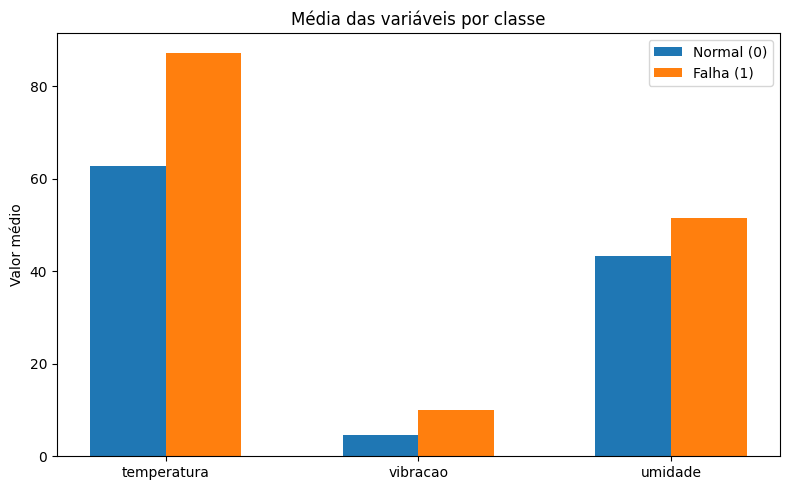

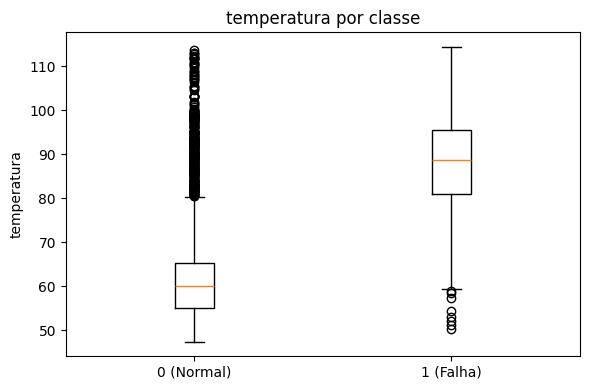

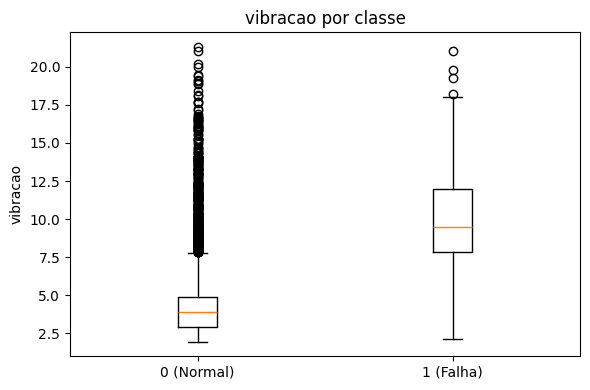

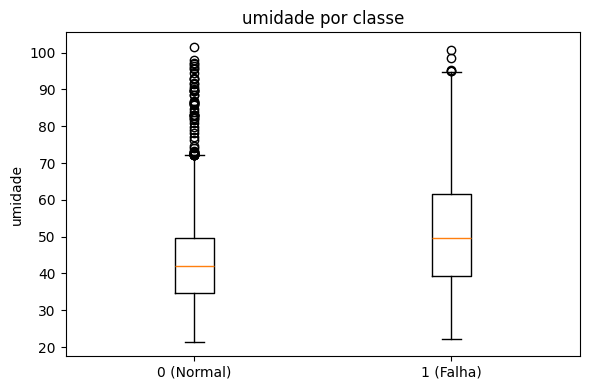

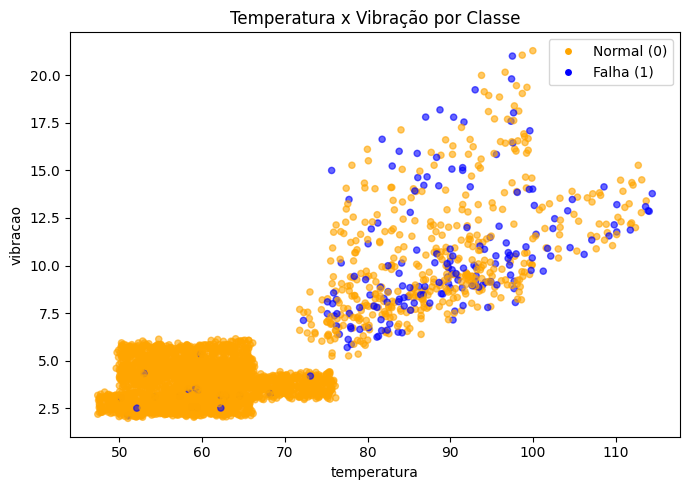

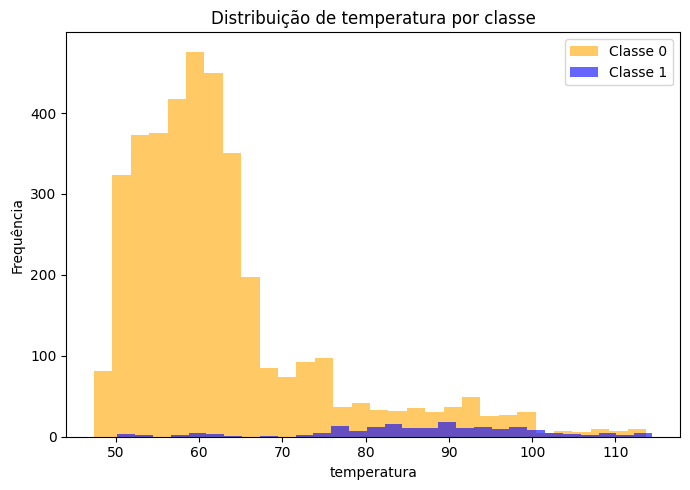

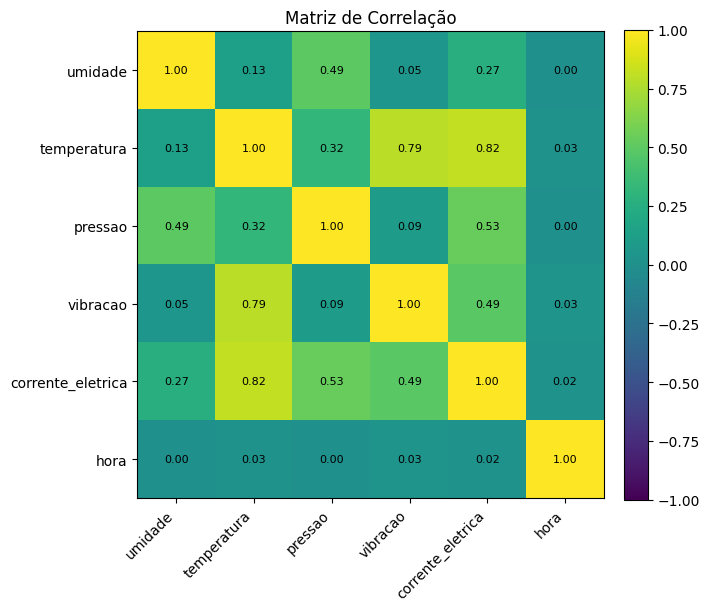

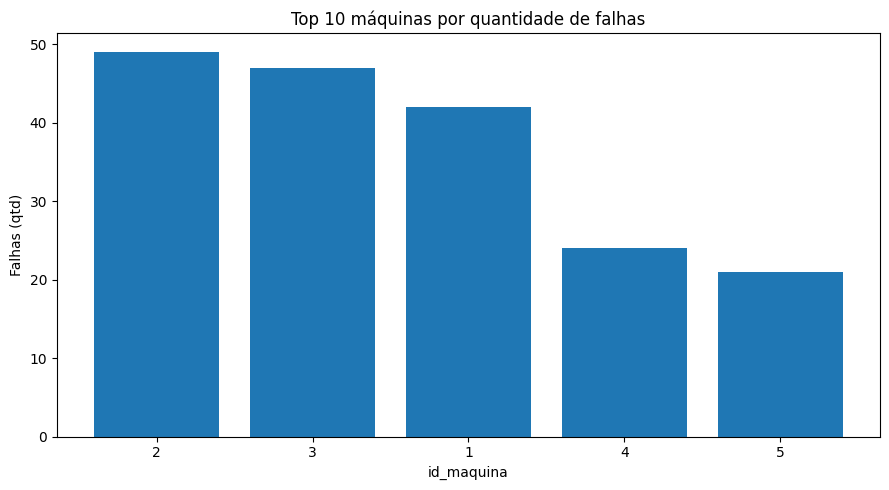

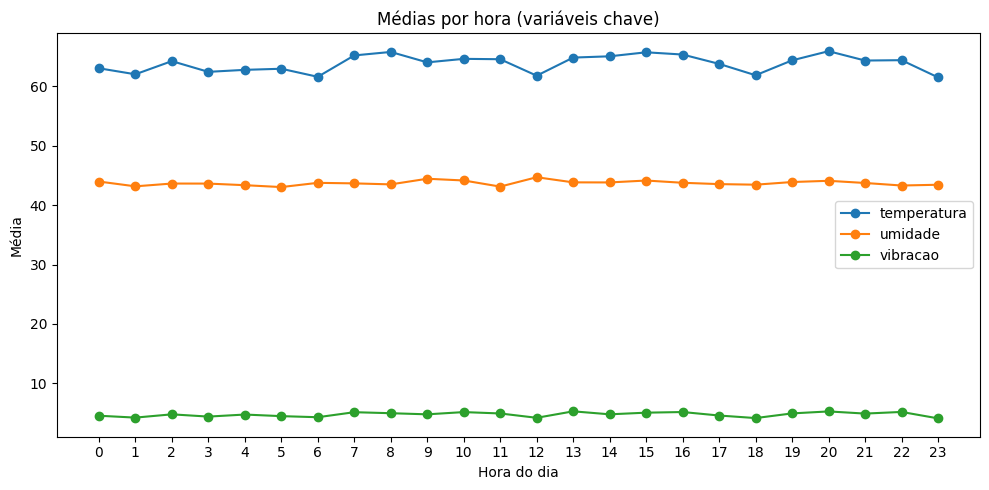

🔄 Treino: 2800 | Teste: 1200

 MODELOS

 Regressão Logística...
    Acurácia: 0.9517
    CV: 0.9507 (0.0029)

 Random Forest...
    Acurácia: 0.9533
    CV: 0.9514 (0.0040)

 SVM...
    Acurácia: 0.9542
    CV: 0.9546 (0.0009)

 KNN...
    Acurácia: 0.9442
    CV: 0.9450 (0.0035)

 RESULTADOS FINAIS
1 SVM                  | Acurácia: 0.9542 | CV: 0.9546
2 Random Forest        | Acurácia: 0.9533 | CV: 0.9514
3 Regressão Logística  | Acurácia: 0.9517 | CV: 0.9507
Grafico KNN                  | Acurácia: 0.9442 | CV: 0.9450


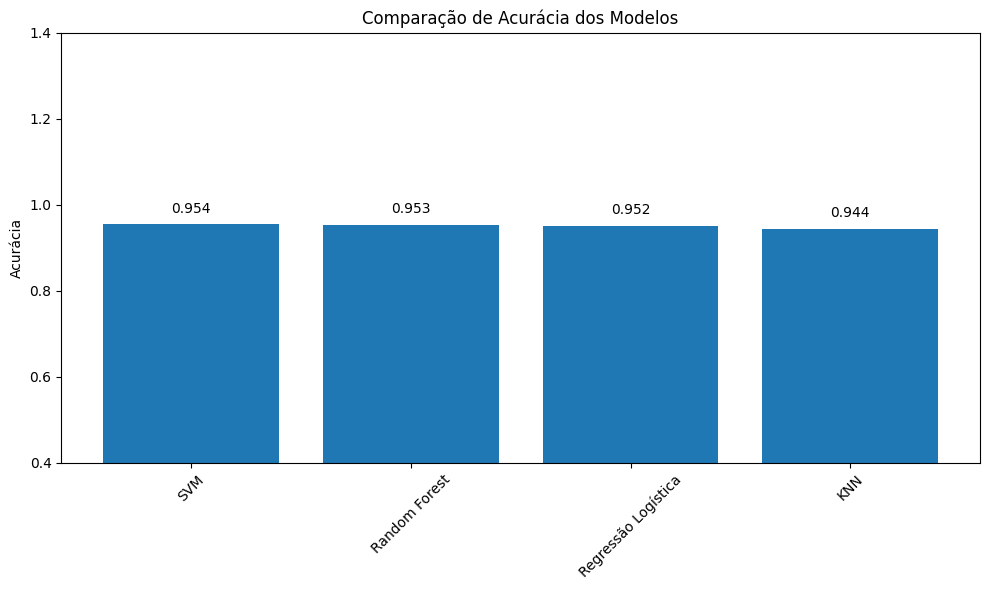


 MELHOR MODELO: SVM
   Acurácia: 0.9542
   CV Score: 0.9546

 RELATÓRIO - SVM
------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1145
           1       0.00      0.00      0.00        55

    accuracy                           0.95      1200
   macro avg       0.48      0.50      0.49      1200
weighted avg       0.91      0.95      0.93      1200


 MATRIZ DE CONFUSÃO:
TN: 1145  |  FP:    0
FN:   55  |  TP:    0

 SIMULAÇÃO TEMPO REAL (últimas 5 leituras):
Leitura 1: Máq.3 | NORMAL (3.9%) | Real: 0 ✓
   Temp: 58.1°C | Vibr: 4.19 | Corr: 32.9A
Leitura 2: Máq.2 | NORMAL (4.5%) | Real: 0 ✓
   Temp: 53.7°C | Vibr: 2.40 | Corr: 23.5A
Leitura 3: Máq.1 | NORMAL (4.5%) | Real: 0 ✓
   Temp: 55.6°C | Vibr: 2.74 | Corr: 30.2A
Leitura 4: Máq.5 | NORMAL (3.7%) | Real: 0 ✓
   Temp: 54.3°C | Vibr: 5.49 | Corr: 12.6A
Leitura 5: Máq.5 | NORMAL (3.7%) | Real: 0 ✓
   Temp: 57.4°C | Vibr: 5.37 | Corr: 14.2A

 Conexão fe

In [ ]:

import pandas as pd
import numpy as np
import pyodbc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


SERVER = 'localhost'
DATABASE = 'SistemaMonitoramento_ML_v4'
USERNAME = 'pyUser'
PASSWORD = 'pyuser123456'
ODBC_DRIVER = 'ODBC Driver 17 for SQL Server'  

# ------------------------------------------------
# Conexão
# ------------------------------------------------
def conectar_banco():
    """Conecta ao SQL Server"""
    try:
        print("🔌 Conectando ao banco...")
        connection_string = (
            f"DRIVER={{{ODBC_DRIVER}}};"
            f"SERVER={SERVER};"
            f"DATABASE={DATABASE};"
            f"UID={USERNAME};"
            f"PWD={PASSWORD};"
            "TrustServerCertificate=Yes;"
        )
        conn = pyodbc.connect(connection_string)
        print("Conectado")
        return conn
    except Exception as e:
        print(f"Erro: {e}")
        return None

# ------------------------------------------------
# Carga de dados
# ------------------------------------------------
def carregar_dados(conn):
    """Carrega dados para ML"""
    try:
        query = """
        SELECT 
            id_maquina,
            DATEPART(HOUR, data_hora_leitura) AS hora,
            corrente_eletrica,
            pressao,
            temperatura,
            umidade,
            vibracao,
            qualidade_sinal,
            temperatura_ambiente,
            CASE WHEN turno = 'MANHA' THEN 1 WHEN turno = 'TARDE' THEN 2 ELSE 3 END AS turno_num,
            falha_proximas_2h AS target
        FROM VW_DADOS_ML
        WHERE corrente_eletrica IS NOT NULL 
          AND pressao IS NOT NULL 
          AND temperatura IS NOT NULL 
          AND umidade IS NOT NULL 
          AND vibracao IS NOT NULL
        """
        df = pd.read_sql(query, conn)

        # Coerção para numérico 
        num_cols = [
            'id_maquina','hora','corrente_eletrica','pressao','temperatura',
            'umidade','vibracao','qualidade_sinal','temperatura_ambiente','turno_num','target'
        ]
        for c in num_cols:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors='coerce')
        df = df.dropna(subset=['temperatura','vibracao','umidade','pressao','corrente_eletrica','target'])

        print(f" {len(df)} registros carregados")

        # Distribuição da classe
        falhas = int(df['target'].sum())
        total = len(df)
        print(f"Falhas: {falhas}/{total} ({(falhas/total*100 if total else 0):.1f}%)")
        return df
    except Exception as e:
        print(f" Erro ao carregar: {e}")
        return None

# ------------------------------------------------
# GRÁFICOS 
# ------------------------------------------------
def gerar_graficos_analise_falhas(df, target_col='target'):
    """Barras de médias por classe, boxplots por classe e histograma comparativo."""
    # 1) Barras de médias por classe
    cols_media = ['temperatura', 'vibracao', 'umidade']
    valid = [c for c in cols_media if c in df.columns]
    if len(valid) >= 1:
        medias = df.groupby(target_col)[valid].mean().T
        plt.figure(figsize=(8,5))
        plt.bar(np.arange(len(valid))-0.15, medias[0].values, width=0.3, label='Normal (0)')
        if 1 in medias.columns:
            plt.bar(np.arange(len(valid))+0.15, medias[1].values, width=0.3, label='Falha (1)')
        plt.xticks(range(len(valid)), valid, rotation=0)
        plt.title('Média das variáveis por classe')
        plt.ylabel('Valor médio')
        plt.legend()
        plt.tight_layout()
        plt.show()

    # 2) Boxplots por classe (temperatura, vibracao, umidade)
    for col in ['temperatura', 'vibracao', 'umidade']:
        if col in df.columns:
            plt.figure(figsize=(6,4))
            data0 = df.loc[df[target_col]==0, col].dropna()
            data1 = df.loc[df[target_col]==1, col].dropna()
            plt.boxplot([data0, data1], labels=['0 (Normal)','1 (Falha)'])
            plt.title(f'{col} por classe')
            plt.ylabel(col)
            plt.tight_layout()
            plt.show()

    # 3) Dispersão simples temperatura x vibração (colorido por classe)
    if {'temperatura','vibracao',target_col}.issubset(df.columns):
        cores = df[target_col].map({0:'orange',1:'blue'}).fillna('gray')
        plt.figure(figsize=(7,5))
        plt.scatter(df['temperatura'], df['vibracao'], c=cores, alpha=0.6, s=20)
        plt.xlabel('temperatura')
        plt.ylabel('vibracao')
        plt.title('Temperatura x Vibração por Classe')
        from matplotlib.lines import Line2D
        plt.legend(handles=[
            Line2D([0],[0], marker='o', color='w', label='Normal (0)', markerfacecolor='orange'),
            Line2D([0],[0], marker='o', color='w', label='Falha (1)', markerfacecolor='blue')
        ])
        plt.tight_layout()
        plt.show()

    # 4) Histograma comparativo (temperatura)
    if {'temperatura', target_col}.issubset(df.columns):
        plt.figure(figsize=(7,5))
        for cls, cor in zip([0,1], ['orange','blue']):
            vals = df.loc[df[target_col]==cls, 'temperatura'].dropna()
            if not vals.empty:
                plt.hist(vals, bins=30, alpha=0.6, label=f'Classe {cls}', color=cor)
        plt.xlabel('temperatura')
        plt.ylabel('Frequência')
        plt.title('Distribuição de temperatura por classe')
        plt.legend()
        plt.tight_layout()
        plt.show()

def gerar_heatmap_correlacao(df):
    """Heatmap simples de correlação das numéricas principais."""
    cols = [c for c in ['umidade','temperatura','pressao','vibracao','corrente_eletrica','hora']
            if c in df.columns]
    if len(cols) < 2:
        return
    corr = df[cols].corr().values
    labels = cols
    plt.figure(figsize=(0.7*len(cols)+3, 0.7*len(cols)+3))
    im = plt.imshow(corr, vmin=-1, vmax=1)
    plt.xticks(np.arange(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(np.arange(len(labels)), labels)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title('Matriz de Correlação')
    # anotações
    for i in range(len(labels)):
        for j in range(len(labels)):
            plt.text(j, i, f"{corr[i, j]:.2f}", ha="center", va="center", fontsize=8)
    plt.tight_layout()
    plt.show()

def gerar_analise_por_maquina(df, target_col='target'):
    """Falhas por máquina (top 10)"""
    if {'id_maquina', target_col}.issubset(df.columns):
        falhas = (df.groupby('id_maquina')[target_col].sum()
                    .sort_values(ascending=False).head(10))
        plt.figure(figsize=(9,5))
        plt.bar(falhas.index.astype(str), falhas.values)
        plt.title('Top 10 máquinas por quantidade de falhas')
        plt.xlabel('id_maquina')
        plt.ylabel('Falhas (qtd)')
        plt.tight_layout()
        plt.show()

def gerar_analise_temporal(df, hora_col='hora', cols=('temperatura','umidade','vibracao')):
    """Médias por hora (24h) das variáveis chave."""
    cols = [c for c in cols if c in df.columns]
    if not cols or hora_col not in df.columns:
        return
    m = df.groupby(hora_col)[cols].mean().sort_index()
    plt.figure(figsize=(10,5))
    for c in cols:
        plt.plot(m.index, m[c], marker='o', label=c)
    try:
        plt.xticks(sorted(m.index))
    except Exception:
        pass
    plt.xlabel('Hora do dia')
    plt.ylabel('Média')
    plt.title('Médias por hora (variáveis chave)')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------------------------------------
# Principal
# ------------------------------------------------
def main():
    conn = None
    try:
        # 1) Conectar
        conn = conectar_banco()
        if not conn:
            return

        # 2) Carregar dados
        df = carregar_dados(conn)
        if df is None or df.empty:
            print(" Sem dados para treinar")
            return

        # 3) Preparar dados para ML
        features = ['id_maquina', 'hora', 'corrente_eletrica', 'pressao',
                    'temperatura', 'umidade', 'vibracao', 'qualidade_sinal',
                    'temperatura_ambiente', 'turno_num']
        features = [c for c in features if c in df.columns]
        target_col = 'target'

        # validações
        missing = [c for c in features+[target_col] if c not in df.columns]
        if missing:
            raise ValueError(f"Colunas ausentes no dataset: {missing}")

        X = df[features].apply(pd.to_numeric, errors='coerce')
        y = pd.to_numeric(df[target_col], errors='coerce').astype(int)

        print(f" Features: {len(features)}")
        print(f" Amostras: {len(X)}")
        print(f" Distribuição dos dados:")
        print(f"  Normal: {(y==0).sum()} ({(y==0).mean()*100:.1f}%)")
        print(f"  Falha:  {(y==1).sum()} ({(y==1).mean()*100:.1f}%)")

        # ===== GRÁFICOS SOLICITADOS =====
        gerar_graficos_analise_falhas(df, target_col=target_col)
        gerar_heatmap_correlacao(df)
        gerar_analise_por_maquina(df, target_col=target_col)
        gerar_analise_temporal(df)

        # 4) Split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=42, stratify=y
        )

        # 5) Normalizar
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        print(f"Treino: {len(X_train)} | Teste: {len(X_test)}")

        # 6) Modelos
        print("\n MODELOS")
        print("=" * 30)
        models = {
            'Regressão Logística': LogisticRegression(max_iter=1000, random_state=42),
            'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
            'SVM': SVC(kernel='rbf', random_state=42, probability=True),
            'KNN': KNeighborsClassifier(n_neighbors=5)
        }

        resultados, models_trained = [], {}

        for nome, modelo in models.items():
            print(f"\n {nome}...")
            modelo.fit(X_train_scaled, y_train)
            y_pred = modelo.predict(X_test_scaled)

            accuracy = accuracy_score(y_test, y_pred)
            cv_scores = cross_val_score(modelo, X_train_scaled, y_train, cv=5, scoring='accuracy')

            resultados.append({
                'Modelo': nome,
                'Acurácia': accuracy,
                'CV Média': cv_scores.mean(),
                'CV Desvio': cv_scores.std()
            })
            models_trained[nome] = modelo

            print(f"    Acurácia: {accuracy:.4f}")
            print(f"    CV: {cv_scores.mean():.4f} ({cv_scores.std():.4f})")

        # 7) Comparação
        print("\n RESULTADOS FINAIS")
        print("=" * 40)
        results_df = pd.DataFrame(resultados).sort_values('Acurácia', ascending=False).reset_index(drop=True)
        for i, row in results_df.iterrows():
            medal = "1" if i == 0 else "2" if i == 1 else "3" if i == 2 else "Grafico"
            print(f"{medal} {row['Modelo']:20} | Acurácia: {row['Acurácia']:.4f} | CV: {row['CV Média']:.4f}")

        # 8) Gráfico simples da acurácia
        plt.figure(figsize=(10, 6))
        plt.bar(results_df['Modelo'], results_df['Acurácia'])
        plt.title('Comparação de Acurácia dos Modelos')
        plt.ylabel('Acurácia')
        plt.xticks(rotation=45)
        plt.ylim(0.40, 1.40)
        for i, v in enumerate(results_df['Acurácia']):
            plt.text(i, min(v + 0.02, 0.98), f'{v:.3f}', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

        # 9) Melhor modelo
        melhor_nome = results_df.iloc[0]['Modelo']
        melhor_modelo = models_trained[melhor_nome]
        print(f"\n MELHOR MODELO: {melhor_nome}")
        print(f"   Acurácia: {results_df.iloc[0]['Acurácia']:.4f}")
        print(f"   CV Score: {results_df.iloc[0]['CV Média']:.4f}")

        # 10) Relatório + Matriz de confusão
        y_pred_melhor = melhor_modelo.predict(X_test_scaled)
        print(f"\n RELATÓRIO - {melhor_nome}")
        print("-" * 30)
        print(classification_report(y_test, y_pred_melhor))

        cm = confusion_matrix(y_test, y_pred_melhor)
        print("\n MATRIZ DE CONFUSÃO:")
        print(f"TN: {cm[0,0]:4d}  |  FP: {cm[0,1]:4d}")
        print(f"FN: {cm[1,0]:4d}  |  TP: {cm[1,1]:4d}")

        # 11) Importância (se RF)
        if melhor_nome == 'Random Forest':
            print("\n IMPORTÂNCIA DAS FEATURES:")
            imp = melhor_modelo.feature_importances_
            for feat, val in sorted(zip(features, imp), key=lambda x: x[1], reverse=True):
                print(f"   {feat:22} : {val:.3f}")

        # 12) Simulação "tempo real" (últimas 5 leituras)
        print("\n SIMULAÇÃO TEMPO REAL (últimas 5 leituras):")
        ultimas_5 = X_test.tail(5)
        y_real_5 = y_test.tail(5).values
        for idx, (_, row) in enumerate(ultimas_5.iterrows()):
            X_scaled = scaler.transform(row.values.reshape(1, -1))
            pred = melhor_modelo.predict(X_scaled)[0]
            prob_texto = ""
            if hasattr(melhor_modelo, 'predict_proba'):
                prob = melhor_modelo.predict_proba(X_scaled)[0][1]
                prob_texto = f" ({prob:.1%})"
            real = y_real_5[idx]
            status = "FALHA" if pred == 1 else "NORMAL"
            ok = "✓" if pred == real else "✗"
            print(f"Leitura {idx+1}: Máq.{int(row['id_maquina']) if 'id_maquina' in row else '-'} | {status}{prob_texto} | Real: {real} {ok}")
            if 'temperatura' in row and 'vibracao' in row and 'corrente_eletrica' in row:
                print(f"   Temp: {row['temperatura']:.1f}°C | Vibr: {row['vibracao']:.2f} | Corr: {row['corrente_eletrica']:.1f}A")

    except Exception as e:
        import traceback
        print(f"\n ERRO: {e}")
        traceback.print_exc()
    finally:
        if conn:
            try:
                conn.close()
                print("\n Conexão fechada")
            except:
                pass

if __name__ == "__main__":
    main()
